####    IMPLEMENTATION OF LOCALITY SENSITIVE HASHING FOR QUERY SEARCHING

In this notebook we will implement an LSH method, whihch searches for the nearest neighbours of a query sentence from scratch.

In [1]:
# Importing libraries
import requests
import pandas as pd
import numpy as np
from io import StringIO 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import random
random.seed(42)

In [4]:
res = requests.get('https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt')
# create dataframe
fin = open('data_folder/data1.csv', 'w')
fin.write(res.text)
fin.close

data = pd.read_csv(StringIO(res.text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [5]:
# we take all samples from both sentence A and B
sentences = data["sentence_A"].tolist()
sentence_b = data["sentence_B"].tolist()
sentences.extend(sentence_b)  # merge them
print(len(set(sentences)))
print(sentences[3])

4802
The kids are playing outdoors near a man with a smile


In [6]:
urls = [
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.train.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2013/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/images.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2015/images.test.tsv'
]

locations = [
    'data_folder/data2.csv',
    'data_folder/data3.csv',
    'data_folder/data4.csv',
    'data_folder/data5.csv',
    'data_folder/data6.csv',
    'data_folder/data7.csv',
    'data_folder/data8.csv'
]

for i, url in enumerate(urls):
    res = requests.get(url)
    # Save in data folder
    fin = open(locations[i], 'w')
    fin.write(res.text)
    fin.close
    # extract to dataframe
    data = pd.read_csv(StringIO(res.text), sep='\t', header=None, error_bad_lines=False)
    # add to columns 1 and 2 to sentences list
    sentences.extend(data[1].tolist())
    sentences.extend(data[2].tolist())
    

b'Skipping line 191: expected 3 fields, saw 4\nSkipping line 206: expected 3 fields, saw 4\nSkipping line 295: expected 3 fields, saw 4\nSkipping line 695: expected 3 fields, saw 4\nSkipping line 699: expected 3 fields, saw 4\n'
b'Skipping line 104: expected 3 fields, saw 4\nSkipping line 181: expected 3 fields, saw 4\nSkipping line 317: expected 3 fields, saw 4\nSkipping line 412: expected 3 fields, saw 5\nSkipping line 508: expected 3 fields, saw 4\n'


We make a set of sentences and it has 14504 sentences

In [7]:
sentences = [word for word in list(set(sentences)) if type(word) is str]
print(len(sentences))

14504


In [40]:
# Building a random vocabulary for all the shingles of these
K = 4   # K = 4,5 shingles size

def make_shingles(text: str, k: int) -> list:
    shingles = []
    for i in range(len(text)-k+1):
        shingles.append(text[i:i+k])
    return set(shingles) #list(set(shingles))

all_shingles = []
for sentence in sentences:
    shingles = make_shingles(sentence, K)
    for shingle in shingles:
        all_shingles.append(shingle)

all_shingles = list(set(all_shingles))

def make_vocab(all_shingles:list) -> dict:
    newlist = random.sample(all_shingles, len(all_shingles))
    print(len(all_shingles))
    vocab = {}
    for i,shingle in enumerate(newlist):
        vocab[shingle] = i
    return vocab

vocabulary = make_vocab(all_shingles)

print(len(vocabulary))


41970
41970


The vocabulary has a total of 41970 shingles. Now we will make the 100 signature arrays which will be used for Minhashing

In [41]:
# Made the vocabulary, now we can make one hot vectors of the sentences, then we will form their signatures
signature_array = []
np.random.seed(42)

L = 100
for i in range(L):
    arr = np.arange(0,len(vocabulary))
    np.random.shuffle(arr)
    signature_array.append(arr)

print(signature_array[0][:5])
print(signature_array[1][:5])

[ 4580 13611  4091  1503 36638]
[17989 24608 34424 28658 28675]


We will make the sparse vectors for each sentence and then minhash them into their respective 100 length signatures

In [42]:
def make_svector(text: str, k: int, vocab:dict) ->np.array:
    shingle = make_shingles(text,k)
    svector = np.zeros(len(vocab))
    for sh in shingle:
        if sh in vocab.keys():
            svector[vocab[sh]] = 1
    return svector

def make_signature(svect:np.array, sig_arr : list) -> np.array:
    signature = np.zeros(len(sig_arr))
    for i, arr in enumerate(sig_arr):
        for j, sig in enumerate(sig_arr[i]):
            if (svect[sig] == 1):
                signature[i] = j
                break
    return signature

signatures = []
for i,text in enumerate(sentences):
    if (i%1000 == 0):
        print(i)
    sparr = make_svector(text,K,vocabulary)
    signatures.append(make_signature(sparr, signature_array))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


Nice, so we have made all the signatures and now we can make the cp (candidate pairs dictionary)

In [44]:
def split_vector(signature: np.array, b:int) -> list:
    assert len(signature) % b == 0
    r = int(len(signature) / b)
    # code splitting signature in b parts
    subvecs = []
    for i in range(0, len(signature), r):
        strlist = [str(int(s)) for s in signature[i : i+r]]
        string = ','.join(strlist) 
        subvecs.append(string)
    return subvecs

no_of_splits = 20

def make_candidate_pairs(signatures: list, no_of_splits:int) -> list:
    candidate_pairs = []
    for i in range(no_of_splits):
        candidate_pairs.append({})
    for j,sig in enumerate(signatures):
        if(j%1000 == 0):
            print("j = ",j)
        
        split_vect = split_vector(sig,no_of_splits)
        for i in range(no_of_splits): 
            if split_vect[i] not in candidate_pairs[i].keys():
                candidate_pairs[i][split_vect[i]] = [j]
            else:
                candidate_pairs[i][split_vect[i]].append(j)
    return candidate_pairs

cp = make_candidate_pairs( signatures[:5],no_of_splits)


j =  0


Note: numpy.ndarrays, lists are not hashable, so we convert the vectors into comma separated variables

In [45]:
candidate_pairs = make_candidate_pairs( signatures,no_of_splits)

j =  0
j =  1000
j =  2000
j =  3000
j =  4000
j =  5000
j =  6000
j =  7000
j =  8000
j =  9000
j =  10000
j =  11000
j =  12000
j =  13000
j =  14000


As we can see out of ~ 14500 sentences, ~ 13200 buckets were formed, which is source of concern as it means that a high percent of sentences did not collide with any other, so this is a potential source of improvement. 

In [47]:
print(len(candidate_pairs))
print(len(candidate_pairs[10]))

20
13237


In [48]:
def ANN(text:str, cp, vocab:dict, k:int, b:int, sig_arr:list, sentences: list) -> list:
    spvect = make_svector(text,k,vocabulary)
    signatur = make_signature(spvect , sig_arr)
    split_vect = split_vector(signatur, b)
    ann = []
    for i in range(b):
        if split_vect[i] in (cp[i]).keys():
            ann.append(cp[i][split_vect[i]])
    ans = []
    for sent in ann:
        for i in sent:
            ans.append(sentences[i])
    ans = list(set(ans))
    return ans

Printing an example:-

In [51]:
text = "A boy is happily playing the piano"
# text = ""
ann = ANN(text, candidate_pairs, vocabulary, K,
          no_of_splits, signature_array, sentences)
for i in ann:
    print(i)

A boy is happily playing the piano
The boy isn't playing the piano happily
A boy is playing guitar
One boy is happily playing a piano
There is no boy playing guitar


Finding the jaccard similarities of the various candidate pairs formed

In [52]:
def jaccard(a, b):
    ans = 0
    for i in range(len(a)):
        if a[i] in b:
            ans = ans +1
    return ans/len(a)

jaccard_values = []

for subdict in candidate_pairs:
    for key in subdict:
        if (len(subdict[key])) > 1:
            a = subdict[key][0]
            b = subdict[key][1]
            a = list(make_shingles(sentences[a], K))
            b = list(make_shingles(sentences[b], K))
            jaccard_values.append(jaccard(a,b))

There are ~ 15900, shingles formed

In [54]:
print(len(jaccard_values))

15941


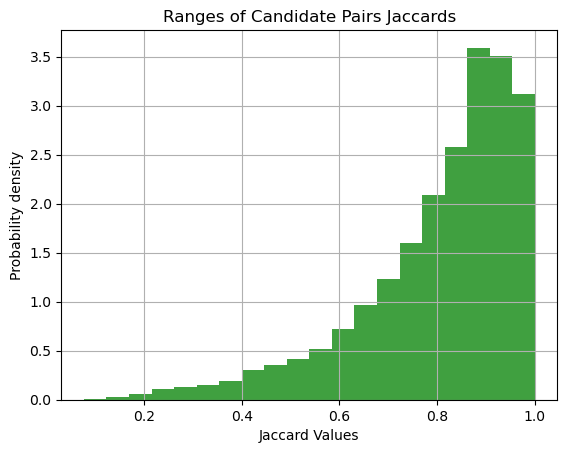

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# # Fixing random state for reproducibility
# np.random.seed(19680801)

# mu, sigma = 100, 15
# x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(jaccard_values, 20, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Jaccard Values')
plt.ylabel('Probability density')
plt.title('Ranges of Candidate Pairs Jaccards')
plt.grid(True)
plt.savefig('Ranges of Candidate Pairs Jaccards')
plt.show()